# 1. Importar librerías

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.signal import butter, lfilter,freqs, freqz,sosfilt, sosfreqz
from scipy.optimize import curve_fit
from scipy.fftpack import fft, ifft

import numpy as np

# 2. Cargar datos

In [0]:

with open("data/DATALOG_Angulos.txt", "r") as f:
    DATALOG_Angulos= f.readlines()


with open("data/DATALOG_Angulos2.txt", "r") as f:
    DATALOG_Angulos2= f.readlines()
A_R = 16384.0  #Datalog/A_R da aceleracion     32768/2
G_R = 131.072    #Datalog/G_R da angulo Giroscopio 32768/250

# 3. Definición de métodos

In [0]:
#Funcion para estructurar Datos (Vector de diccionarios con dimension = numero de reinicios)
#Ejemplo Estructura:
"""   [{'ax': array([-2028, -1892, -2006, ..., -1741, -1755, -1770]),
      'ay': array([  2, 172,  60, ...,  84, -79, 111]),
      'az': array([ 646,  625,  618, ..., 1049, 1036, 1022]),
      'gx': array([-65,  -2, -37, ..., 150, 219, 121]),
      'gy': array([-22,   0, -17, ..., -29, -36, -97]),
      'gz': array([  51,   43,  -33, ...,   57, -135, -211])},
     {'ax': array([-2028, -1892, -2006, ..., -1741, -1755, -1770]),
      'ay': array([  2, 172,  60, ...,  84, -79, 111]),
      'az': array([ 646,  625,  618, ..., 1049, 1036, 1022]),
      'gx': array([-65,  -2, -37, ..., 150, 219, 121]),
      'gy': array([-22,   0, -17, ..., -29, -36, -97]),
      'gz': array([  51,   43,  -33, ...,   57, -135, -211])},
     {'ax': array([-2028, -1892, -2006, ..., -1741, -1755, -1770]),
      'ay': array([  2, 172,  60, ...,  84, -79, 111]),
      'az': array([ 646,  625,  618, ..., 1049, 1036, 1022]),
      'gx': array([-65,  -2, -37, ..., 150, 219, 121]),
      'gy': array([-22,   0, -17, ..., -29, -36, -97]),
      'gz': array([  51,   43,  -33, ...,   57, -135, -211])}] """


def Datalog_DataStruc(Experimento): # Convierte datos sensados en el experimento en datos estructurados
    Cabecera = ["ax","ay","az","gx","gy","gz","thetaG","phiG","thetaA","phiA","theta","phi"];
    DatosEstructurados =[] # Contiene los conjuntos de datos de todo el experimento (su dimension esta determinada por el numero de reinicios del experimento)
    Datanp = np.array([[Experimento[i].split(",")[j] for i in range(len(Experimento))] for j in range(12)] ) #Conversion de tipo 
    Inicio_Pruebas = np.where(Datanp == "ax")[1] #Esto contiene una lista con las posiciones de los encabezados
    print(len(Inicio_Pruebas))
    if(len(Inicio_Pruebas) == 1):
        SecData = Datanp[:,1 :].astype(np.float)
#Selecciona el conjunto de datos entre encabezados
        SecData_Estructurada = dict( zip(  Experimento[0][:-1].split(",")  , SecData ) ) #Se genera un dicionario para tener data estructurada
        DatosEstructurados.append(SecData_Estructurada) #Se agrega el conjunto de datos
        return DatosEstructurados
    else:
        for i in range(0,len(Inicio_Pruebas)):
            SecData = Datanp[    :  ,    Inicio_Pruebas[i-1]+1 : Inicio_Pruebas[i]-1     ].astype(np.float)   #Selecciona el conjunto de datos entre encabezados
            SecData_Estructurada = dict( zip(  Experimento[0][:-1].split(",")  , SecData ) ) #Se genera un dicionario para tener data estructurada
            DatosEstructurados.append(SecData_Estructurada) #Se agrega el conjunto de datos
        return DatosEstructurados
    
def RecortarData(Datos_Experimento,fs,ti,tf):  #Graficar Datos estructurados del experimento, con conversion de unidades
    A = int(fs*ti)
    B = int(fs*tf)
    Data = {}
    Data["ax"] = Datos_Experimento["ax"][A:B]
    Data["ay"] = Datos_Experimento["ay"][A:B]
    Data["az"] = Datos_Experimento["az"][A:B]
    Data["gx"] = Datos_Experimento["gx"][A:B]
    Data["gy"] = Datos_Experimento["gy"][A:B]
    Data["gz"] = Datos_Experimento["gz"][A:B]
    
    Data["thetaG"] = Datos_Experimento["thetaG"][A:B]
    Data["phiG"] = Datos_Experimento["phiG"][A:B]
    Data["thetaA"] = Datos_Experimento["thetaA"][A:B]
    Data["phiA"] = Datos_Experimento["phiA"][A:B]
    Data["theta"] = Datos_Experimento["theta"][A:B]
    Data["phi"] = Datos_Experimento["phi"][A:B]
    return Data

def Graficar_DataExperimento(Datos_Experimento,fs):  #Graficar Datos estructurados del experimento, con conversion de unidades
    t = np.arange(len(   Datos_Experimento["ax"]    ))/fs
    
    plot_data = {
        1: {
            'title':'Aceleraciones',
            'ylabel': 'Aceleracion [g]',
            'labels': ['ax', 'ay', 'az']
        },
        2: {
            'title':'Giroscopio',
            'ylabel': 'Angulo [°/s]',
            'labels': ['gx', 'gy', 'gz']
        },
        3: {
            'title':'Angulos Giroscopio',
            'ylabel': 'Angulo [°]',
            'labels': ['thetaG', 'phiG']
        },
        4: {
            'title':'Angulos Acelerometro',
            'ylabel': 'Angulo [°]',
            'labels': ['thetaA', 'phiA']
        },
        5: {
            'title':'Angulos',
            'ylabel': 'Angulo [°]',
            'labels': ['theta', 'phi']
        }
    }
    num_data = len(plot_data.keys())
    for k in plot_data.keys():
        title = plot_data[k]['title']
        ylabel = plot_data[k]['ylabel']
        d_ylabel = r'$\frac{d}{dt}$ ' + ylabel
        labels = plot_data[k]['labels']
        
        plt.figure(k, figsize = [15,5])
        plt.figure(k + num_data, figsize = [15,5])
        for label in labels:
            d_label = r'$\frac{d}{dt}$ ' + label
            y = Datos_Experimento[label]
            dy_dt = np.gradient(y, t)
            
            plt.figure(k)
            plt.plot(t, y, label=label)
            
            plt.figure(k + num_data)
            plt.plot(t, dy_dt, label=d_label)
        
        yl = [ylabel, d_ylabel]
        kk = [k, k + num_data]
        for k in range(2):
            plt.figure(kk[k])
            plt.legend(loc='upper center')
            plt.title(title)
            plt.ylabel(yl[k])
            plt.xlabel('t [s]')
    
def Aceleracion_to_angulo(Datos_Experimento): # Calcula phi y theta apartir de aceleraciones aceleraciones
    ax = Datos_Experimento["ax"]/A_R
    ay = Datos_Experimento["ay"]/A_R
    az = Datos_Experimento["az"]/A_R
    
    
    _Φ = np.arctan(  -ax / np.sqrt(ay**2 + az**2))
    _θ = np.arctan(  ay / np.sqrt(ax**2 + az**2))
    return [_Φ, _θ]

def MagnitudAceleracion(Datos_Experimento): # Calcula la magnitud de la aceleracion
    ax = Datos_Experimento["ax"]/A_R
    ay = Datos_Experimento["ay"]/A_R
    az = Datos_Experimento["az"]/A_R
    
    return np.sqrt(ax**2+ay**2+az**2)

def FiltroComplementario(theta,G,theta_a,dt,A,B): #Aplica filtro complementario a datos de la IMU
    return A*(theta + G*dt) + B*theta_a

def Get_Angulos(Datos_Experimento,fs):  # Obtiene los angulos en cada instante de tiempo utilizando el FiltroComplementario
    Φ_a , θ_a = Aceleracion_to_angulo(Datos_Experimento)
    yaw_a = np.zeros( len(Φ_a)  )
    
    θ = np.empty( len(Φ_a) -1 )
    Φ = np.empty( len(Φ_a) -1 )
    yaw = np.empty( len(Φ_a) -1 )
    G_x = Datos_Experimento["gx"]/G_R
    G_y = Datos_Experimento["gy"]/G_R
    G_z = Datos_Experimento["gz"]/G_R

    for i in range(1,len(Φ_a)-1):
        θ[i] = FiltroComplementario(θ[i-1],G_x[i-1],θ_a[i-1],1/fs,0.98,0.02)
        Φ[i] = FiltroComplementario(Φ[i-1],G_y[i-1],Φ_a[i-1],1/fs,0.98,0.02)
        yaw[i] = FiltroComplementario(yaw[i-1],G_z[i-1],yaw_a[i-1],1/fs,1,0.0)
    return θ , Φ , yaw
    
    
def FFT(Data,fs):
    N = len(Data)
    T = 1/fs
    yf = fft(Data)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    return [xf, yf, N]

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = butter(order, high, btype='low')
    return b, a


def butter_lowpass_filter(data, highcut, fs, order=5):
    b, a = butter_lowpass( highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# 4. Análisis

In [6]:
Datos_Angulos = Datalog_DataStruc(DATALOG_Angulos)
Datos_Angulos2  = Datalog_DataStruc(DATALOG_Angulos2)

8
2


In [7]:
len(Datos_Angulos2)

2

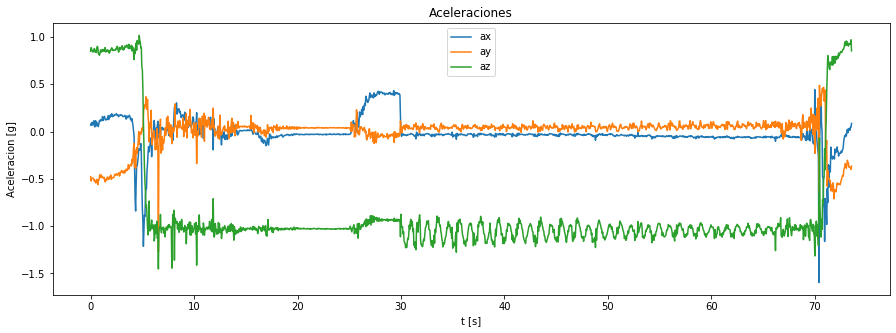

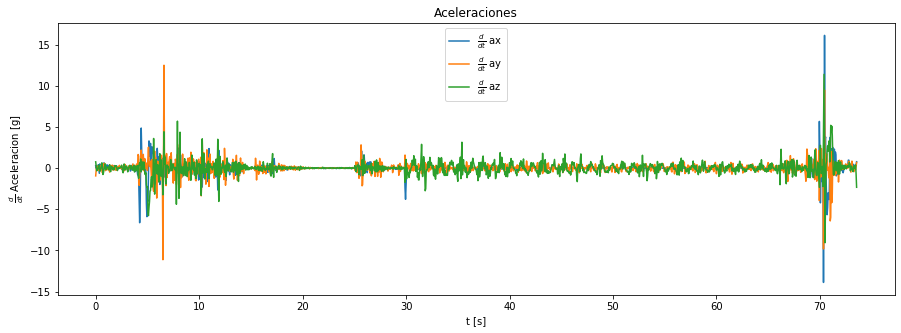

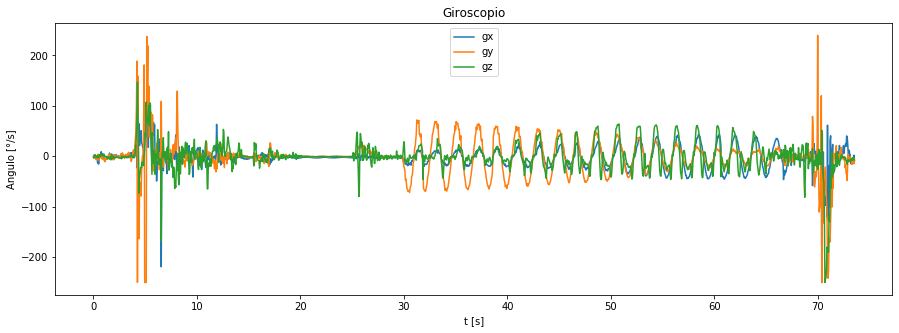

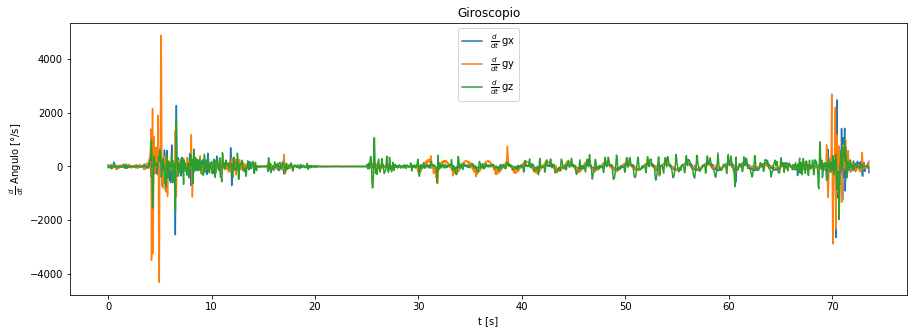

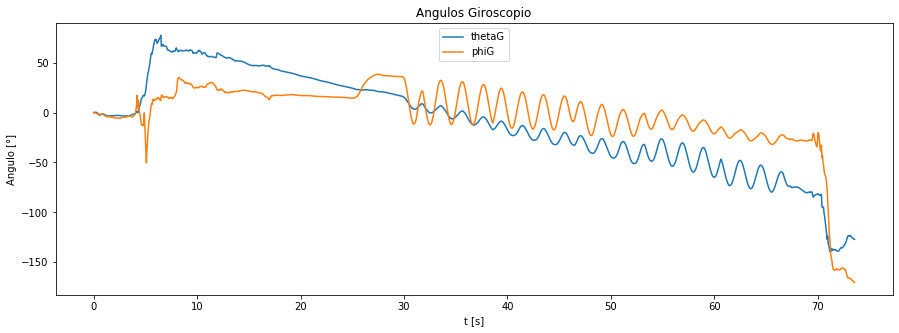

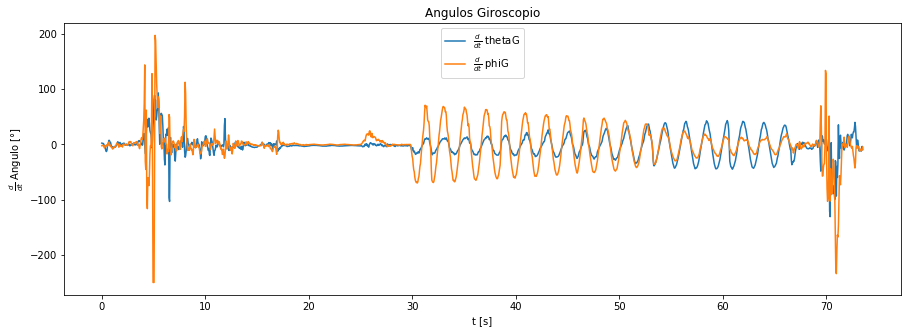

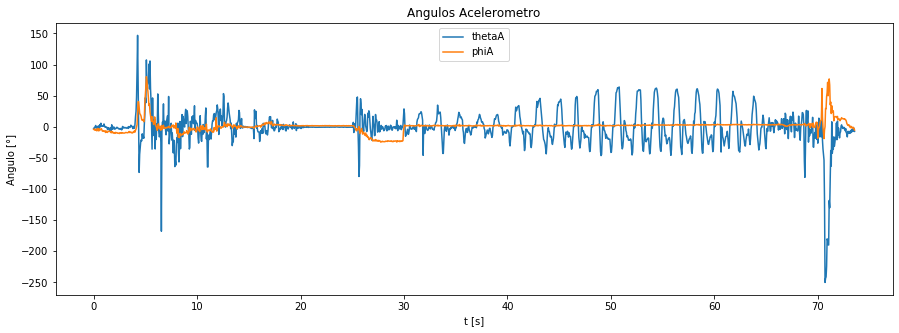

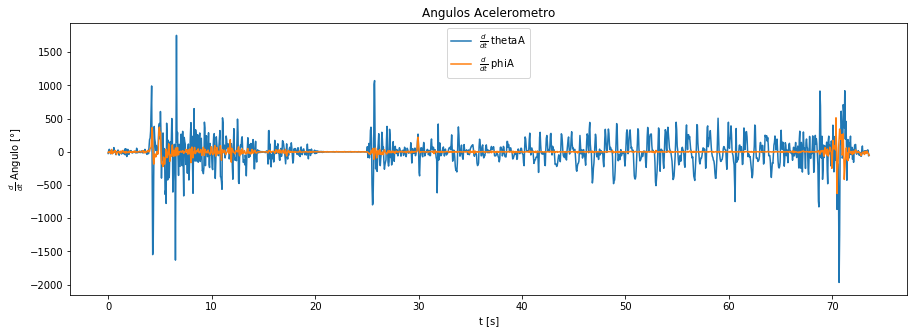

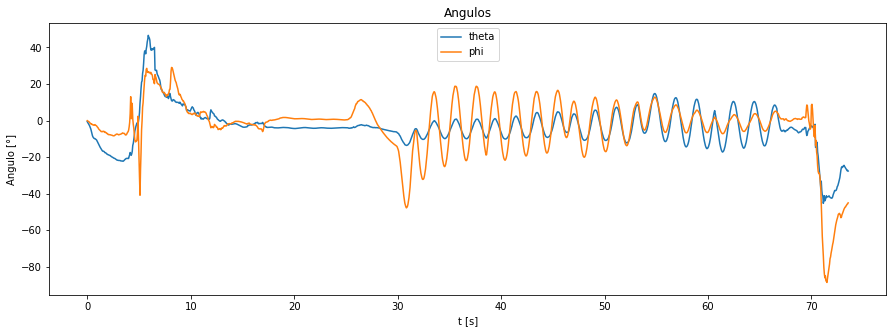

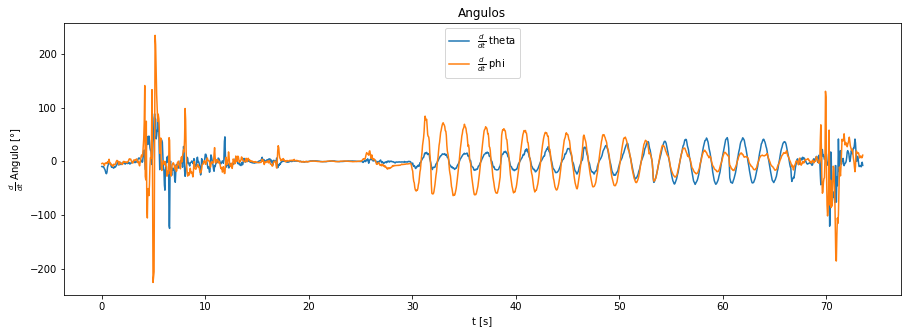

In [8]:
fs = 20 #Frecuencia de muestreo
Graficar_DataExperimento(Datos_Angulos2[1],fs) # Grafica muestras de aceleracion y giroscopio de la IMU

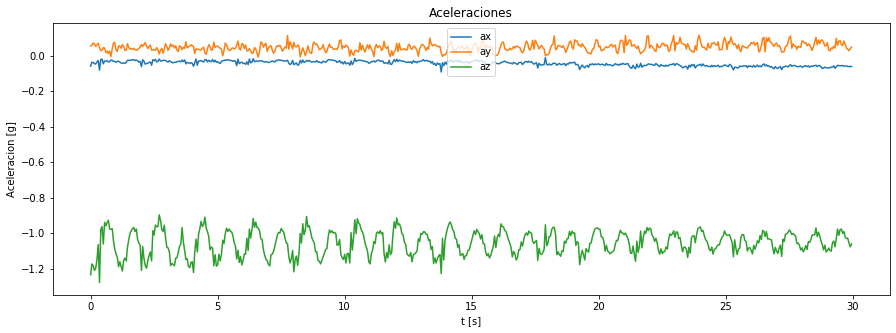

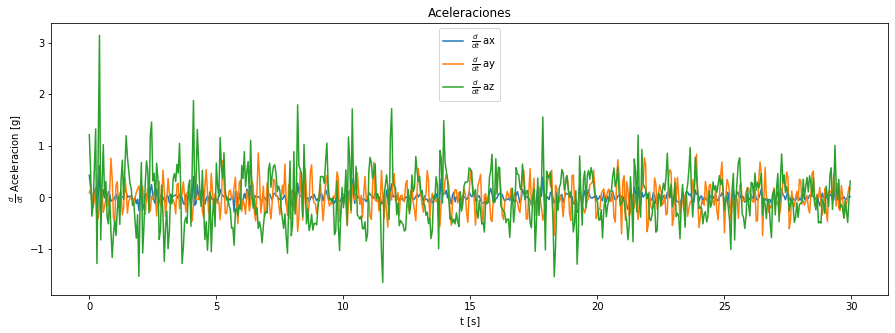

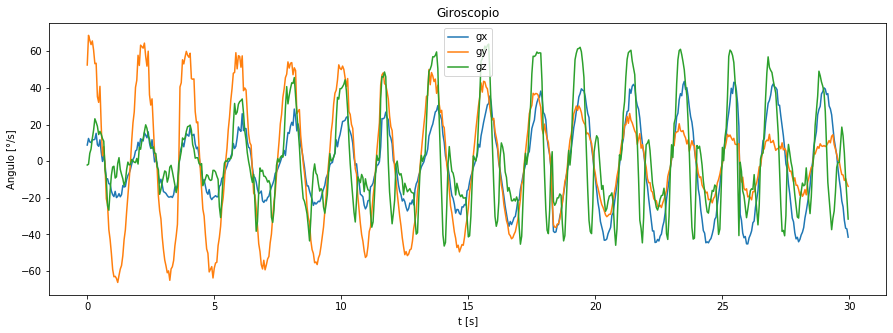

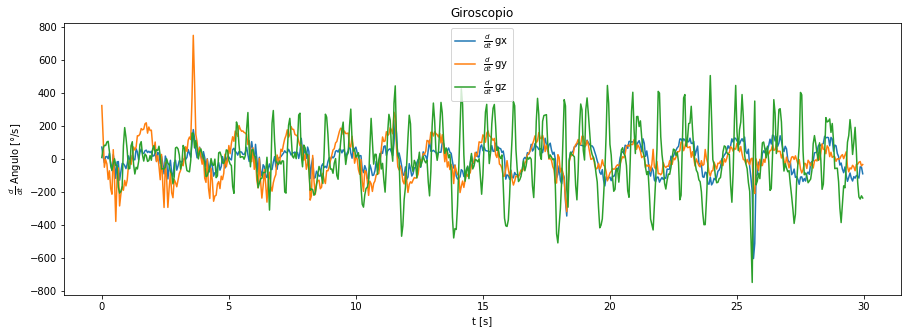

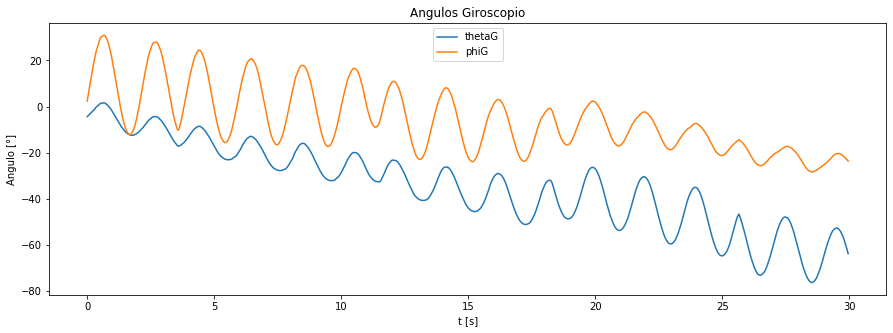

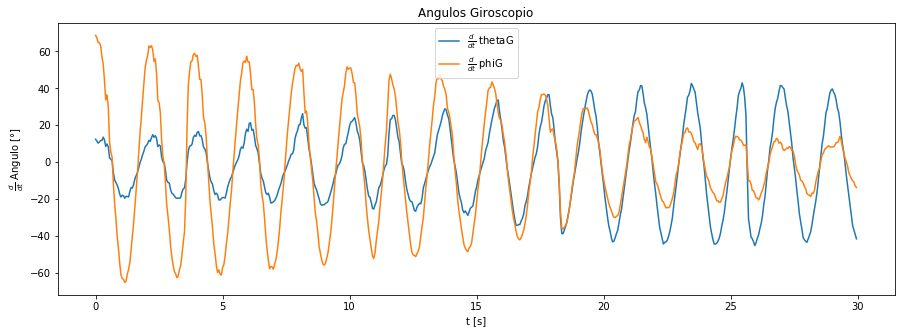

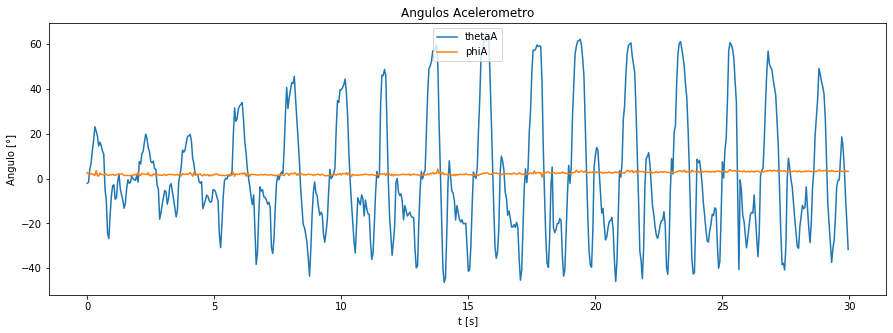

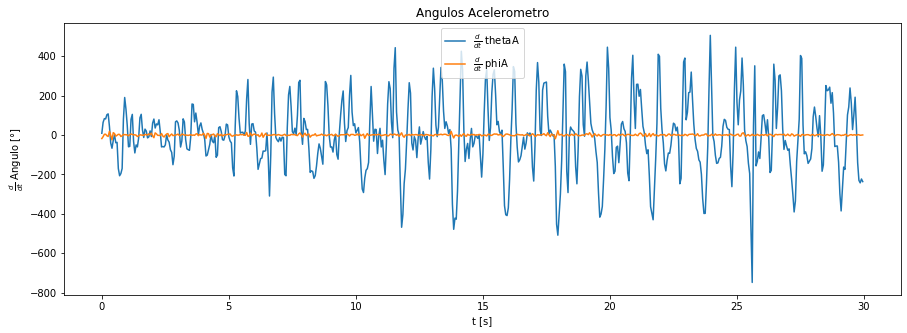

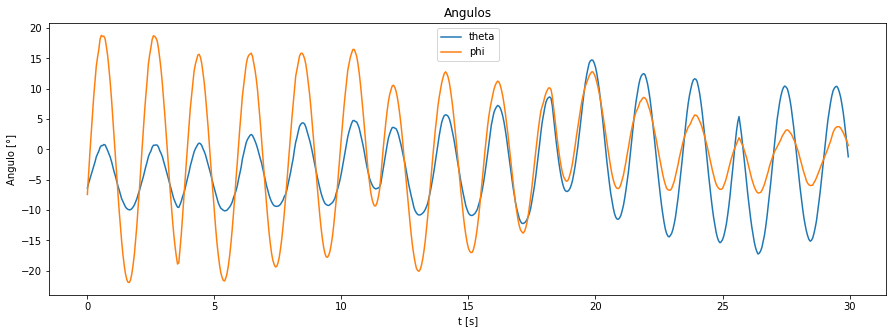

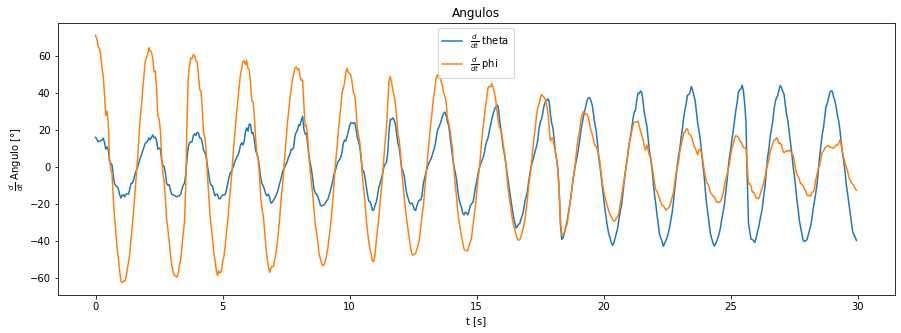

In [9]:
Data = RecortarData(Datos_Angulos2[1],fs,35,65)   # RecortarData(Data, Frecuencia de muestreo, Tinicio, TFinal)
Graficar_DataExperimento(Data,fs) # Grafica muestras de aceleracion y giroscopio de la IMU

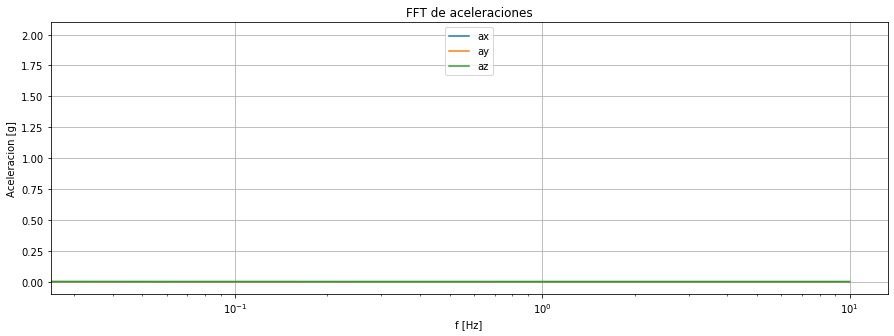

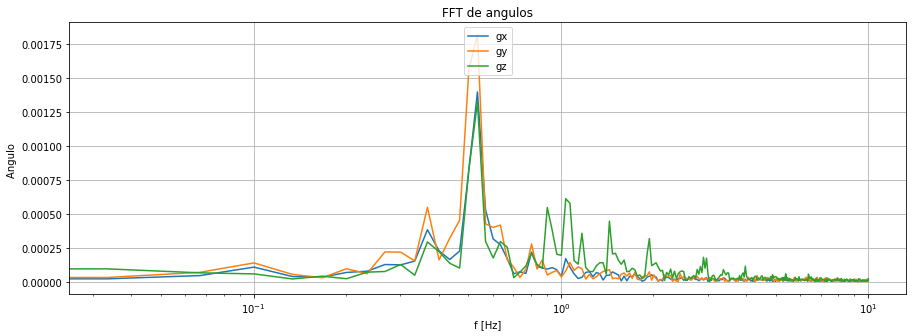

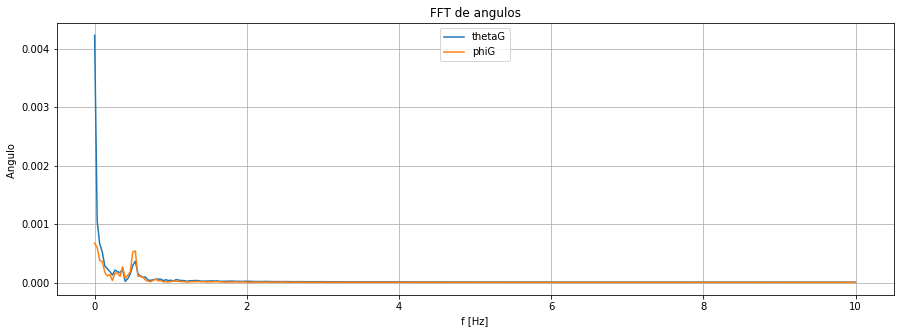

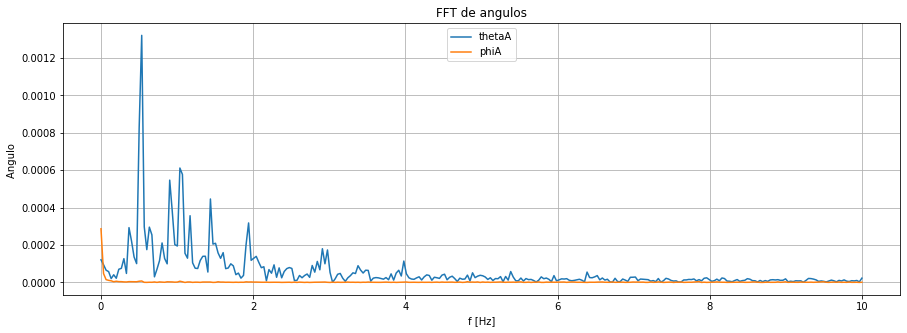

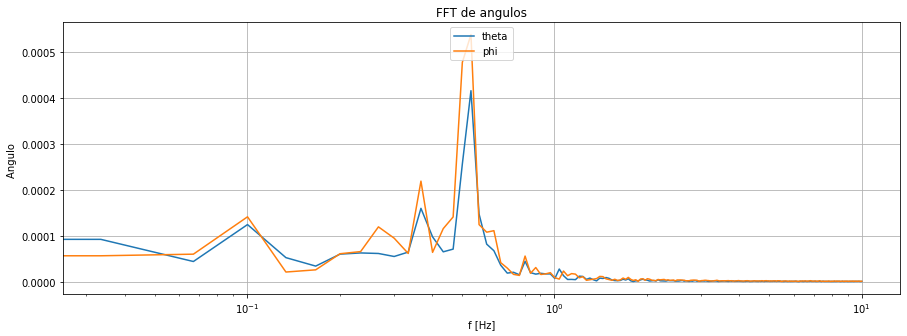

In [10]:
FFT_a = {} #FFT de aceleraciones
f_a = {} #Frecuencias de la FFT de aceleraciones
N_a = {} #Numero de muestras de las aceleraciones

FFT_g = {} #FFT de angulos
f_g = {} #Frecuencias de la FFT de angulos
N_g = {} #Numero de muestras de lasangulos


f_a["ax"],FFT_a["ax"],N_a["ax"] = FFT(Data["ax"]/A_R+1,fs) # Se quita a la brava la componente de DC dada por la gravedad 
f_a["ay"],FFT_a["ay"],N_a["ay"] = FFT(Data["ay"]/A_R-0.25,fs) # Se quita a la brava la componente de DC dada por la gravedad
f_a["az"],FFT_a["az"],N_a["az"] = FFT(Data["az"]/A_R+0.2,fs) # Se quita a la brava la componente de DC dada por la gravedad
#f_a["Ma"],FFT_a["Ma"],N_a["Ma"] = FFT(M_Aceleracion-1.06,fs) # Se quita a la brava la componente de DC dada por la gravedad

f_a["gx"],FFT_a["gx"],N_a["gx"] = FFT(Data["gx"]/A_R,fs) 
f_a["gy"],FFT_a["gy"],N_a["gy"] = FFT(Data["gy"]/A_R,fs) 
f_a["gz"],FFT_a["gz"],N_a["gz"] = FFT(Data["gz"]/A_R,fs) 

f_a["thetaG"],FFT_a["thetaG"],N_a["thetaG"] = FFT(Data["thetaG"]/A_R,fs) 
f_a["phiG"],FFT_a["phiG"],N_a["phiG"] = FFT(Data["phiG"]/A_R,fs) 
f_a["thetaA"],FFT_a["thetaA"],N_a["thetaA"] = FFT(Data["thetaA"]/A_R,fs) 
f_a["phiA"],FFT_a["phiA"],N_a["phiA"] = FFT(Data["phiA"]/A_R,fs) 
f_a["theta"],FFT_a["theta"],N_a["theta"] = FFT(Data["theta"]/A_R,fs) 
f_a["phi"],FFT_a["phi"],N_a["phi"] = FFT(Data["phi"]/A_R,fs) 


plt.figure(1, figsize = [15,5])
plt.title("FFT de aceleraciones")
plt.ylabel('Aceleracion [g]')
plt.xlabel('f [Hz]')
plt.plot(f_a["ax"], 2.0/N_a["ax"] * np.abs(FFT_a["ax"][0:N_a["ax"]//2]),label='ax')
plt.plot(f_a["ay"], 2.0/N_a["ay"] * np.abs(FFT_a["ay"][0:N_a["ay"]//2]),label='ay')
plt.plot(f_a["az"], 2.0/N_a["az"] * np.abs(FFT_a["az"][0:N_a["az"]//2]),label='az')
plt.xscale('log')
plt.legend(loc='upper center')
plt.grid()
plt.show()



plt.figure(3, figsize = [15,5])
plt.title("FFT de angulos")
plt.ylabel('Angulo ')
plt.xlabel('f [Hz]')
plt.plot(f_a["gx"], 2.0/N_a["gx"] * np.abs(FFT_a["gx"][0:N_a["gx"]//2]),label='gx')
plt.plot(f_a["gy"], 2.0/N_a["gy"] * np.abs(FFT_a["gy"][0:N_a["gy"]//2]),label='gy')
plt.plot(f_a["gz"], 2.0/N_a["gz"] * np.abs(FFT_a["gz"][0:N_a["gz"]//2]),label='gz')
plt.xscale('log')
plt.legend(loc='upper center')
plt.grid()
plt.show()


plt.figure(3, figsize = [15,5])
plt.title("FFT de angulos")
plt.ylabel('Angulo ')
plt.xlabel('f [Hz]')
plt.plot(f_a["thetaG"], 2.0/N_a["thetaG"] * np.abs(FFT_a["thetaG"][0:N_a["thetaG"]//2]),label='thetaG')
plt.plot(f_a["phiG"], 2.0/N_a["phiG"] * np.abs(FFT_a["phiG"][0:N_a["phiG"]//2]),label='phiG')
plt.legend(loc='upper center')
plt.grid()
plt.show()

plt.figure(3, figsize = [15,5])
plt.title("FFT de angulos")
plt.ylabel('Angulo ')
plt.xlabel('f [Hz]')
plt.plot(f_a["thetaA"], 2.0/N_a["thetaA"] * np.abs(FFT_a["thetaA"][0:N_a["thetaA"]//2]),label='thetaA')
plt.plot(f_a["phiA"], 2.0/N_a["phiA"] * np.abs(FFT_a["phiA"][0:N_a["phiA"]//2]),label='phiA')
plt.legend(loc='upper center')
plt.grid()
plt.show()

plt.figure(3, figsize = [15,5])
plt.title("FFT de angulos")
plt.ylabel('Angulo ')
plt.xlabel('f [Hz]')
plt.semilogx(f_a["theta"], 2.0/N_a["theta"] * np.abs(FFT_a["theta"][0:N_a["theta"]//2]),label='theta')
plt.semilogx(f_a["phi"], 2.0/N_a["phi"] * np.abs(FFT_a["phi"][0:N_a["phi"]//2]),label='phi')
plt.legend(loc='upper center')
plt.grid()
plt.show()


In [0]:
t = np.arange(len(   Data["ax"] )-1)/fs

In [32]:

derivada_theta = (np.diff(Data['theta'])/np.diff(Data['ax']))*np.diff(Data['ax']) + (np.diff(Data['theta'])/np.diff(Data['ay']))*np.diff(Data['ay'])+(np.diff(Data['theta'])/np.diff(Data['az']))*np.diff(Data['az']) + (np.diff(Data['theta'])/np.diff(Data['gx']))*np.diff(Data['gx'])+ (np.diff(Data['theta'])/np.diff(Data['gy']))*np.diff(Data['gy'])
derivada_phi = (np.diff(Data['phi'])/np.diff(Data['ax']))*np.diff(Data['ax']) + (np.diff(Data['phi'])/np.diff(Data['ay']))*np.diff(Data['ay'])+(np.diff(Data['phi'])/np.diff(Data['az']))*np.diff(Data['az']) + (np.diff(Data['phi'])/np.diff(Data['gx']))*np.diff(Data['gx'])+ (np.diff(Data['phi'])/np.diff(Data['gy']))*np.diff(Data['gy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


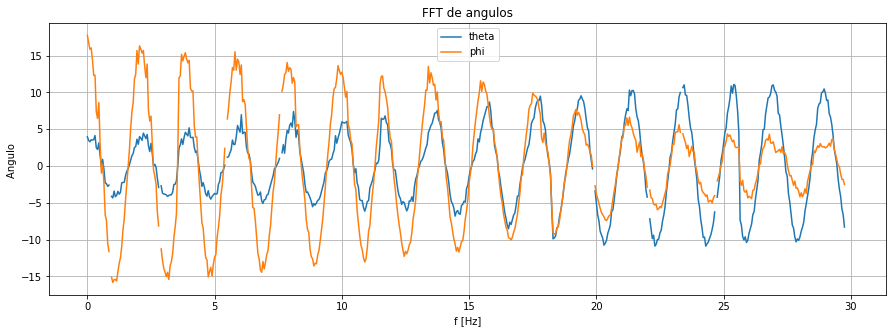

In [33]:
plt.figure(figsize = [15,5])
plt.title("FFT de angulos")
plt.ylabel('Angulo ')
plt.xlabel('f [Hz]')
plt.plot(t,derivada_theta,label='theta')
plt.plot(t,derivada_phi,label='phi')
plt.legend(loc='upper center')
plt.grid()
plt.show()


In [29]:
len(t)

600

In [26]:
len(derivada_theta)

599